<a href="https://colab.research.google.com/github/shivangipandey/langchain-rag-graph-gpt-chatbot/blob/main/rag_training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import urllib.request
from os import getcwd

!mkdir dependency

url = "https://raw.githubusercontent.com/shivangipandey/langchain-rag-graph-gpt-chatbot/main/requirements.txt"
directory = getcwd()
filename = directory + '/requirements.txt'

urllib.request.urlretrieve(url, filename)

('/content/requirements.txt', <http.client.HTTPMessage at 0x7d532a17bd90>)

In [ ]:
!pip install -r requirements.txt

In [4]:
#Add OpenAI related enviroment variables

import os

os.environ["AZURE_OPENAI_API_KEY"]="${}"
os.environ["OPENAI_API_KEY"]="${}"
os.environ["OPENAI_API_BASE"]="${}"
os.environ["OPENAI_API_VERSION"]="2023-09-01-preview"
os.environ["AZURE_OPENAI_CHAT_DEPLOYMENT_NAME"]="gpt-35-turbo-openai"

With this in place, let's test the connectivity with openAI model

In [13]:
#Basic chatmodel setup

import dotenv
import os
from langchain_openai import AzureChatOpenAI
from langchain.schema.messages import HumanMessage, SystemMessage

dotenv.load_dotenv()

chat_model = AzureChatOpenAI(
        base_url = os.getenv("OPENAI_API_BASE"),
        max_tokens = 100,
        validate_base_url=False,
        temperature=0)

#Gives Valid Answer
messages = [
    SystemMessage(
        content="""You're an assistant knowledgeable about
        healthcare. Only answer healthcare-related questions."""
    ),
    HumanMessage(content="What is Medicaid managed care?"),
]

print(chat_model.invoke(messages))

content='Medicaid managed care is a system in which states contract with managed care organizations (MCOs) to provide healthcare services to Medicaid beneficiaries. These MCOs are responsible for coordinating and delivering healthcare services to enrollees in exchange for a set payment from the state. Medicaid managed care aims to improve access to care, enhance quality, and control costs for Medicaid beneficiaries.'


# Set Up a Neo4j Graph Database

Create a Neo4j Account and AuraDB Instance

To get started using Neo4j, you can create a free [Neo4j AuraDB account](https://neo4j.com/cloud/aura-free/). The landing page should look something like this:

Screenshot_2024-01-10_at_9.52.26_AM.13dfb78c613b.avif


Click the Start Free button and create an account. Once you’re signed in, you should see the Neo4j Aura console:

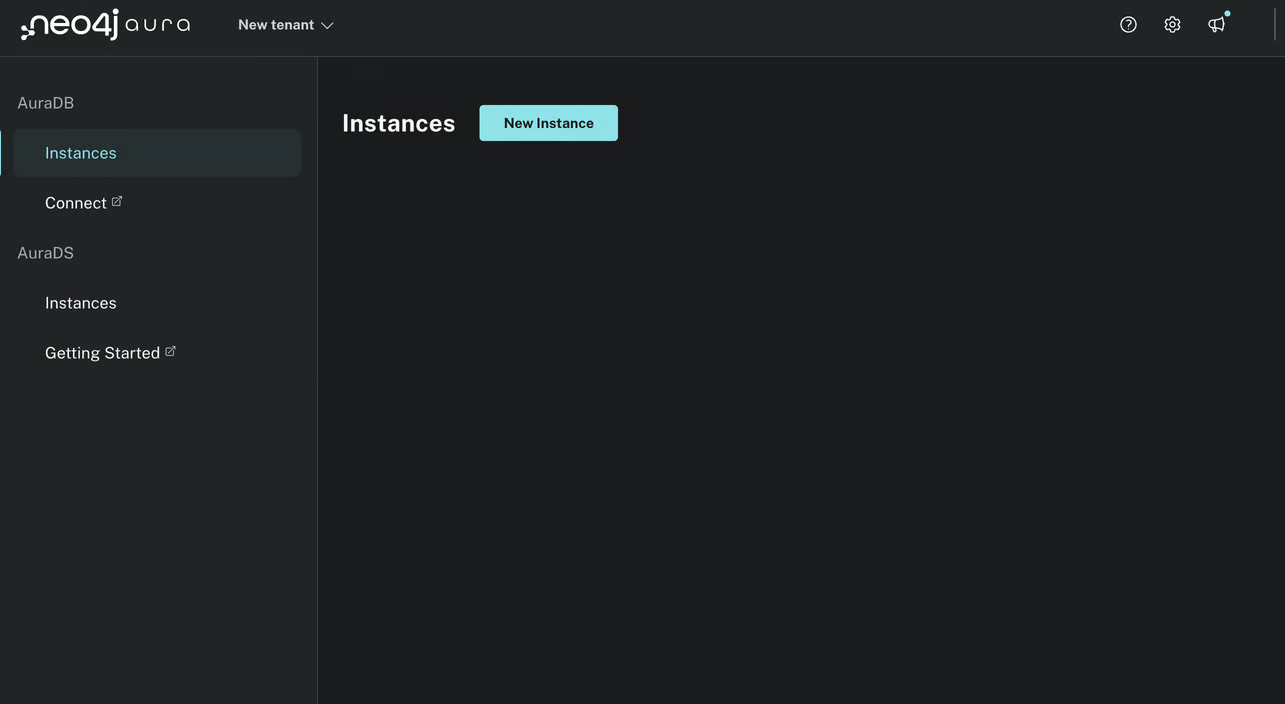

Click New Instance and create a free instance. A modal should pop up similar to this:

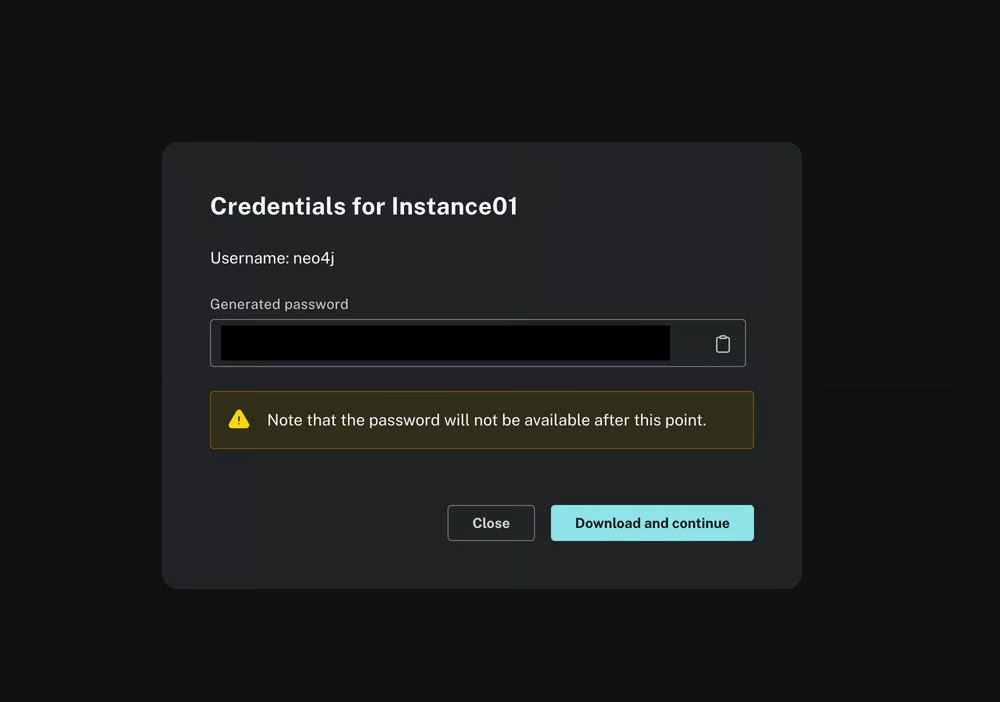

After you click Download and Continue, your instance should be created and a text file containing the Neo4j database credentials should download. Once the instance is created, you’ll see its status is Running. There should be no nodes or relationships yet:

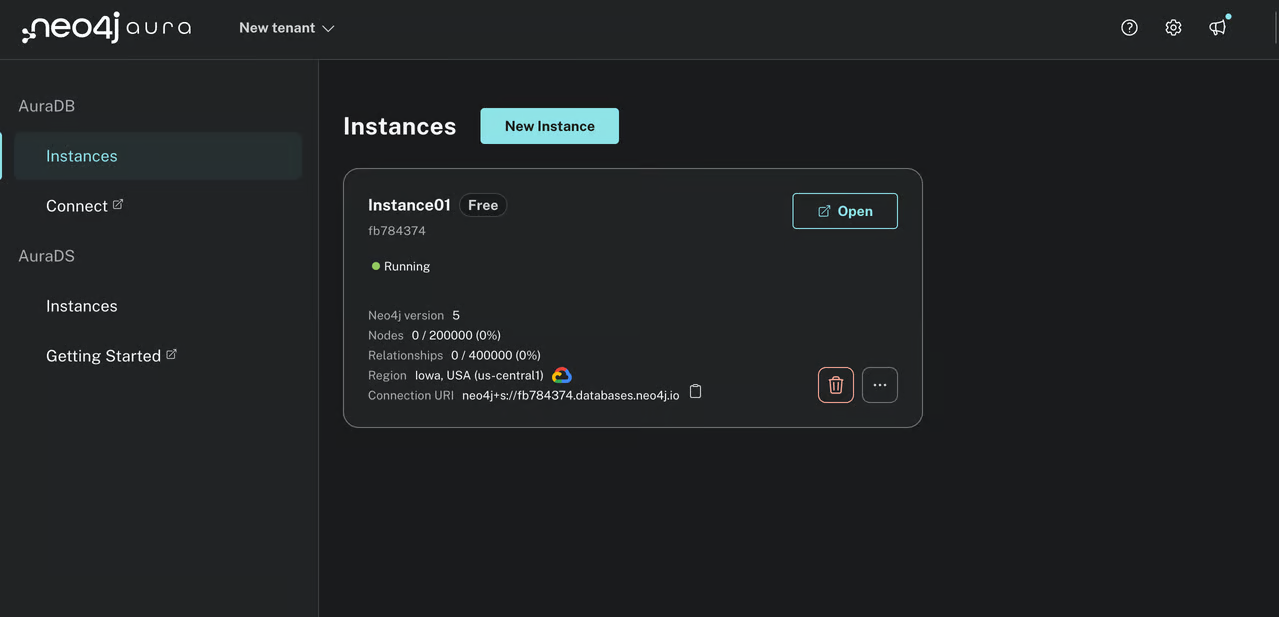

It might take few minutes for the instance to come in 'running' state. Once it does, click on 'Open', which will land you to query tab. If the screen doesn't take password, try disconnecting your vpn and then retrying.

Next, open the text file you downloaded with your Neo4j credentials and copy the NEO4J_URI, NEO4J_USERNAME, and NEO4J_PASSWORD, then set into your env variables :


In [5]:
#neo4j related
os.environ["NEO4J_URI"]="neo4j+s://91767f94.databases.neo4j.io"
os.environ["NEO4J_USERNAME"]="neo4j"
os.environ["NEO4J_PASSWORD"]="{}"

#raw data related
os.environ["HOSPITALS_CSV_PATH"]="https://raw.githubusercontent.com/shivangipandey/langchain-rag-graph-gpt-chatbot/main/hospitals.csv"
os.environ["PAYERS_CSV_PATH"]="https://raw.githubusercontent.com/shivangipandey/langchain-rag-graph-gpt-chatbot/main/payers.csv"
os.environ["PHYSICIANS_CSV_PATH"]="https://raw.githubusercontent.com/shivangipandey/langchain-rag-graph-gpt-chatbot/main/physicians.csv"
os.environ["PATIENTS_CSV_PATH"]="https://raw.githubusercontent.com/shivangipandey/langchain-rag-graph-gpt-chatbot/main/patients.csv"
os.environ["VISITS_CSV_PATH"]="https://raw.githubusercontent.com/shivangipandey/langchain-rag-graph-gpt-chatbot/main/visits.csv"
os.environ["REVIEWS_CSV_PATH"]="https://raw.githubusercontent.com/shivangipandey/langchain-rag-graph-gpt-chatbot/main/reviews.csv"

In [38]:
#test connection with neo4j auraDB

import os
from langchain_community.graphs import Neo4jGraph
from langchain.chains import GraphCypherQAChain
from langchain.prompts import PromptTemplate

graph = Neo4jGraph(
    url=os.getenv("NEO4J_URI"),
    username=os.getenv("NEO4J_USERNAME"),
    password=os.getenv("NEO4J_PASSWORD"),
)

graph.refresh_schema()

Before moving to RAG, we fill first understand Prompt Engineering's application on very high level.

**SystemMessage** tells the model how to behave.

*Try writing something irrelevant in above example?*

Apart from this, you can also try direct query to model.

In [39]:
messages = [
    SystemMessage(
        content="""You're an assistant knowledgeable about
        healthcare. Only answer healthcare-related questions."""
    ),
    HumanMessage(content="How do I change a tire?"),
]

print(chat_model.invoke(messages))

print(chat_model.invoke("What is blood pressure?"))

content="I'm here to help with healthcare-related questions. If you have any health-related inquiries, feel free to ask!"
content='Blood pressure is the force of blood pushing against the walls of the arteries as the heart pumps blood throughout the body. It is measured in millimeters of mercury (mmHg) and is typically expressed as two numbers, such as 120/80 mmHg. The first number (systolic pressure) represents the pressure in the arteries when the heart beats, while the second number (diastolic pressure) represents the pressure in the arteries when the heart is at rest between beats. High'


Note: In these examples, you used .invoke(), but LangChain has other methods that interact with LLMs. For instance, .stream() returns the response one token at time, and .batch() accepts a list of messages that the LLM responds to in one call.

Each method also has an analogous asynchronous method. For instance, you can run .invoke() asynchronously with ainvoke().

### Prompt Templates

LangChain allows you to design modular prompts for your chatbot with prompt templates.

From LangChain’s documentation, *you can think of prompt templates as predefined recipes for generating prompts for language models.*

In [40]:
from langchain.prompts import (
    PromptTemplate,
    SystemMessagePromptTemplate,
    HumanMessagePromptTemplate,
    ChatPromptTemplate,
)

review_system_template_str = """Your job is to use patient
reviews to answer questions about their experience at a
hospital. Use the following context to answer questions.
Be as detailed as possible, but don't make up any information
that's not from the context. If you don't know an answer, say
you don't know.

{context}
"""

review_system_prompt = SystemMessagePromptTemplate(
    prompt=PromptTemplate(
        input_variables=["context"], template=review_system_template_str
    )
)

review_human_prompt = HumanMessagePromptTemplate(
    prompt=PromptTemplate(
        input_variables=["question"], template="{question}"
    )
)

messages = [review_system_prompt, review_human_prompt]
review_prompt_template = ChatPromptTemplate(
    input_variables=["context", "question"],
    messages=messages,
)
context = "I had a great stay!"
question = "Did anyone have a positive experience?"

review_prompt_template.format_messages(context=context, question=question)

[SystemMessage(content="Your job is to use patient\nreviews to answer questions about their experience at a\nhospital. Use the following context to answer questions.\nBe as detailed as possible, but don't make up any information\nthat's not from the context. If you don't know an answer, say\nyou don't know.\n\nI had a great stay!\n"),
 HumanMessage(content='Did anyone have a positive experience?')]

### Chains and LangChain Expression Language (LCEL)

* The glue that connects chat models, prompts, and other objects in LangChain is the chain.
* A chain is nothing more than a sequence of calls between objects in LangChain. (Workflow)
* The recommended way to build chains is to use the LangChain Expression Language (LCEL).
* You can chain together complex pipelines to create your chatbot, and you end up with an object that executes your pipeline in a single method call.

In [41]:
#create a chain with a chat model and prompt template:

#pass questions through review_prompt_template and chat_model in a single function call.
review_chain = review_prompt_template | chat_model

#In essence, this abstracts away all of the internal details of review_chain, allowing you to interact with the chain as if it were a chat model.

context = "I had a great stay!"
question = "Did anyone have a positive experience?"

review_chain.invoke({"context": context, "question": question})

AIMessage(content='Yes, the patient had a great stay at the hospital, indicating a positive experience.')

In [42]:
#add output parser to the chain:

from langchain_core.output_parsers import StrOutputParser

output_parser = StrOutputParser()

review_chain = review_prompt_template | chat_model | output_parser

review_chain.invoke({"context": context, "question": question})

'Yes, the patient had a great stay at the hospital, indicating a positive experience.'

### Retrieval Objects

The goal of *review_chain* is to answer questions about patient experiences in the hospital from their reviews.

So far, you’ve manually passed reviews in as context for the question. While this can work for a small number of reviews, it doesn’t scale well.

 Moreover, even if you can fit all reviews into the model’s context window, there’s no guarantee it will use the correct reviews when answering a question.

To overcome this, you need a **retriever**.

> The process of retrieving relevant documents and passing them to a language model to answer questions is known as retrieval-augmented generation (**RAG**).

# Business Requirements

We want answers to ad-hoc questions about patients, visits, physicians, hospitals, and insurance payers without having to understand a query language like SQL, request a report from an analyst, or wait for someone to build a dashboard.

To accomplish this, your stakeholders want an internal chatbot tool, similar to ChatGPT, that can answer questions about your company’s data. After meeting to gather requirements, you’re provided with a list of the kinds of questions your chatbot should answer:

* What is the current wait time at XYZ hospital?
* Which hospital currently has the shortest wait time?
* At which hospitals are patients complaining about billing and insurance issues?
* Have any patients complained about the hospital being unclean?
* What have patients said about how doctors and nurses communicate with them?
* What are patients saying about the nursing staff at XYZ hospital?
* What was the total billing amount charged to Cigna payers in 2023?
* How many patients has Dr. John Doe treated?
* How many visits are open and what is their average duration in days?
* Which physician has the lowest average visit duration in days?
* How much was billed for patient 789’s stay?
* Which hospital worked with the most Cigna patients in 2023?
* What’s the average billing amount for emergency visits by hospital?
* Which state had the largest percent increase inedicaid visits from 2022 to 2023?

Some subjective questions like -

* Have any patients complained about the hospital being unclean? or What have patients said about how doctors and nurses communicate with them?

## How ?

This means, when presented with a question,
* your chatbot needs to know what type of question (subjective or objective?) is being asked
* which data source to pull from.

Q : How much was billed for patient 789’s stay?

Your chatbot should know it needs to query a database to find the answer.

Q : What have patients said about how doctors and nurses communicate with them?

Your chatbot should know it needs to read and summarize patient reviews.

# Data exploration

Much of the data was derived from a popular [health care dataset](https://www.kaggle.com/datasets/prasad22/healthcare-dataset) on Kaggle.

When mapping it with out internals, assume CSV files to be SQL Tables.

## Data

[hospitals.csv
](https://github.com/shivangipandey/langchain-rag-graph-gpt-chatbot/blob/main/hospitals.csv)

There 30 hospitals and three fields in this file:

* hospital_id: An integer that uniquely identifies a hospital.
* hospital_name: The hospital’s name.
* hospital_state: The state the hospital is located in.

**Description** : records information specific to hospitals, but you can join it to fact tables to answer questions about which patients, physicians, and payers are related to the hospital.

[physicians.csv](https://github.com/shivangipandey/langchain-rag-graph-gpt-chatbot/blob/main/physicians.csv)

The physicians.csv file contains data about the physicians that work for your hospital system. This dataset has the following fields:

* physician_id: An integer that uniquely identifies each physician.
* physician_name: The physician’s name.
* physician_dob: The physician’s date of birth.
* physician_grad_year: The year the physician graduated medical school.
* medical_school: Where the physician attended medical school.
salary: The physician’s salary.

[payers.csv](https://github.com/shivangipandey/langchain-rag-graph-gpt-chatbot/blob/main/payers.csv)

records information about the insurance companies that your hospitals bills for patient visits.

* payer_id: An integer that uniquely identifies each payer.
* payer_name: The payer’s company name.

[reviews.csv](https://github.com/shivangipandey/langchain-rag-graph-gpt-chatbot/blob/main/reviews.csv)

The reviews.csv file contains patient reviews about their experience at the hospital.

chatbot should use this to answer questions about review details and patient experiences.

* review_id: An integer that uniquely identifies a review.
* visit_id: An integer that identifies the patient’s visit that the review was about.
* review: This is the free form text review left by the patient.
* physician_name: The name of the physician who treated the patient.
* hospital_name: The hospital where the patient stayed.
* patient_name: The patient’s name.

[visits.csv](https://github.com/shivangipandey/langchain-rag-graph-gpt-chatbot/blob/main/visits.csv)

records details about every hospital visit your company has serviced. This table that connects hospitals, physicians, patients, and payers. Here are the fields:

* visit_id: The unique identifier of a hospital visit.
* patient_id: The ID of the patient associated with the visit.
* date_of_admission: The date the patient was admitted to the hospital.
* room_number: The patient’s room number.
* admission_type: One of ‘Elective’, ‘Emergency’, or ‘Urgent’.
* chief_complaint: A string describing the patient’s primary reason for being at the hospital.
* primary_diagnosis: A string describing the primary diagnosis made by the physician.
* treatment_description: A text summary of the treatment given by the physician.
* test_results: One of ‘Inconclusive’, ‘Normal’, or ‘Abnormal’.
* discharge_date: The date the patient was discharged from the hospital
* physician_id: The ID of the physician that treated the patient.
* hospital_id: The ID of the hospital the patient stayed at.
* payer_id: The ID of the insurance payer used by the patient.
* billing_amount: The amount of money billed to the payer for the visit.
visit_status: One of ‘OPEN’ or ‘DISCHARGED’.



> This dataset gives you everything you need to answer questions about the relationship between each hospital entity. For example, if you know a physician ID, you can use visits.csv to figure out which patients, payers, and hospitals the physician is associated with. Take a look at what visits.csv looks like in Polars:






Screenshot_2024-01-15_at_8.08.18_PM.fe16f8a318cc.avif


**LangChain Agent**: The LangChain agent is the brain of your chatbot. Given a user query, the agent decides which tool to call and what to give the tool as input. The agent then observes the tool’s output and decides what to return to the user—this is the agent’s response.

**Neo4j AuraDB**: You’ll store both structured hospital system data and patient reviews in a Neo4j AuraDB graph database.

**LangChain Neo4j Cypher Chain**: This chain tries to convert the user query into Cypher, Neo4j’s query language, and execute the Cypher query in Neo4j. The chain then answers the user query using the Cypher query results. The chain’s response is fed back to the LangChain agent and sent to the user.

**LangChain Neo4j Reviews Vector Chain**: Now patient review embeddings are stored in Neo4j. The chain searches for relevant reviews based on those semantically similar to the user query, and the reviews are used to answer the user query.

**Wait Times Function**: the LangChain agent tries to extract a hospital name from the user query. The hospital name is passed as input to a Python function that gets wait times, and the wait time is returned to the agent.

# Graph Databases

Graph data consists of **nodes**, **edges** or **relationships**, and **properties**.

Nodes represent entities, relationships connect entities, and properties provide additional metadata about nodes and relationships.

Storing data in a graph like this has several advantages:

1. **Simplicity**: Modeling real-world relationships between entities is natural in graph databases, reducing the need for complex schemas that require multiple join operations to answer queries.

2. **Relationships**: Graph databases excel at handling complex relationships. Traversing relationships is efficient, making it easy to query and analyze connected data.

3. **Flexibility**: Graph databases are schema-less, allowing for easy adaptation to changing data structures. This flexibility is beneficial for evolving data models.

5. **Performance**: Retrieving connected data is faster in graph databases than in relational databases, especially for scenarios involving complex queries with multiple relationships.

6. **Pattern Matching**: Graph databases support powerful pattern-matching queries, making it easier to express and find specific structures within the data.

Because of this concise data representation, there’s less room for error when an LLM generates graph database queries. This is because you only need to tell the LLM about the nodes, relationships, and properties in your graph database. Contrast this with relational databases where the LLM must navigate and retain knowledge of the table schemas and foreign key relationships throughout your database, leaving more room for error in SQL generation.



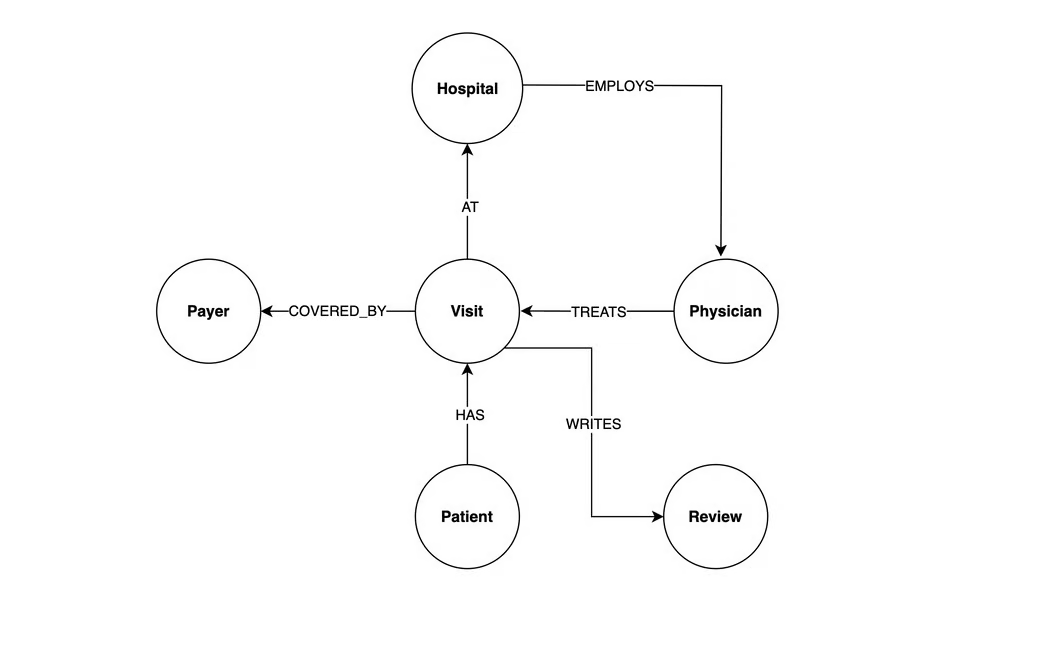

Review nodes have an **embedding** property, which is a vector representation of the patient_name, physician_name, and text properties. This allows you to do vector searches over review

Properties :

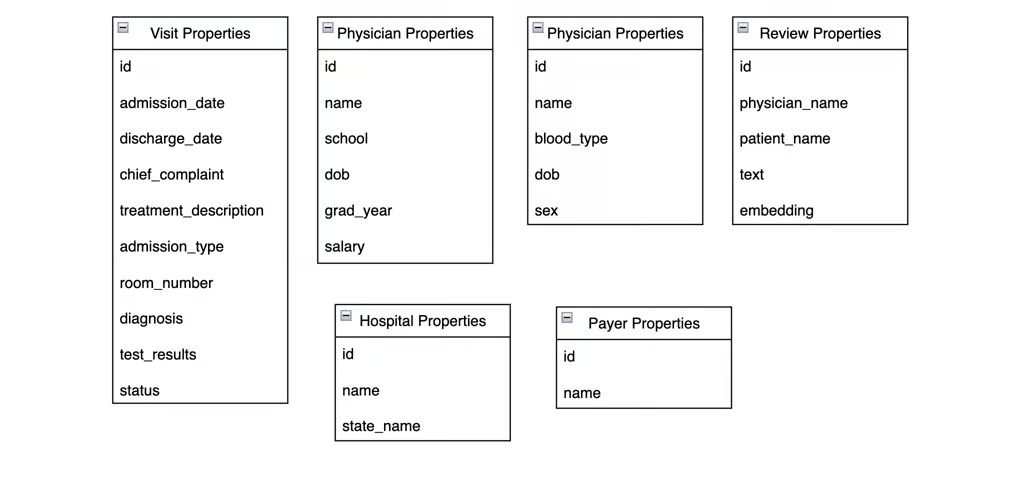

Relationships :    

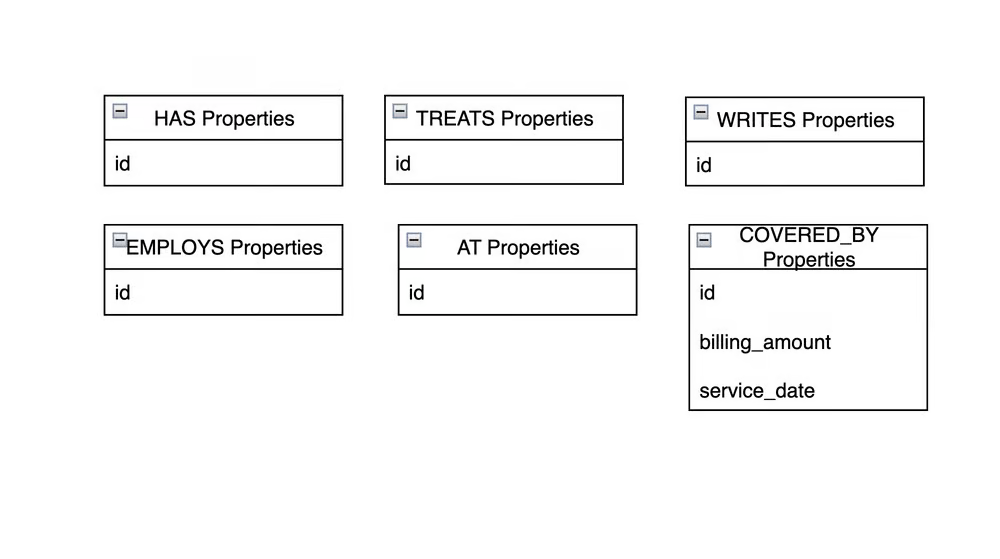


# Upload Data to Neo4j

In [8]:
import os
import logging
from retry import retry
from neo4j import GraphDatabase
import dotenv

dotenv.load_dotenv()

HOSPITALS_CSV_PATH = os.getenv("HOSPITALS_CSV_PATH")
PAYERS_CSV_PATH = os.getenv("PAYERS_CSV_PATH")
PHYSICIANS_CSV_PATH = os.getenv("PHYSICIANS_CSV_PATH")
PATIENTS_CSV_PATH = os.getenv("PATIENTS_CSV_PATH")
VISITS_CSV_PATH = os.getenv("VISITS_CSV_PATH")
REVIEWS_CSV_PATH = os.getenv("REVIEWS_CSV_PATH")

NEO4J_URI = os.getenv("NEO4J_URI")
NEO4J_USERNAME = os.getenv("NEO4J_USERNAME")
NEO4J_PASSWORD = os.getenv("NEO4J_PASSWORD")

In [9]:
NODES = ["Hospital", "Payer", "Physician", "Patient", "Visit", "Review"]

def _set_uniqueness_constraints(tx, node):
    query = f"""CREATE CONSTRAINT IF NOT EXISTS FOR (n:{node})
        REQUIRE n.id IS UNIQUE;"""
    _ = tx.run(query, {})

@retry(tries=100, delay=10)
def load_hospital_graph_from_csv() -> None:
    """Load structured hospital CSV data following
    a specific ontology into Neo4j"""

    driver = GraphDatabase.driver(
        NEO4J_URI, auth=(NEO4J_USERNAME, NEO4J_PASSWORD)
    )

    print("Setting uniqueness constraints on nodes")
    with driver.session(database="neo4j") as session:
        for node in NODES:
            session.execute_write(_set_uniqueness_constraints, node)

#creating nodes

    print("Loading hospital nodes")
    with driver.session(database="neo4j") as session:
        query = f"""
        LOAD CSV WITH HEADERS
        FROM '{HOSPITALS_CSV_PATH}' AS hospitals
        MERGE (h:Hospital {{id: toInteger(hospitals.hospital_id),
                            name: hospitals.hospital_name,
                            state_name: hospitals.hospital_state}});
        """
        _ = session.run(query, {})

    print("Loading payer nodes")
    with driver.session(database="neo4j") as session:
        query = f"""
        LOAD CSV WITH HEADERS
        FROM '{PAYERS_CSV_PATH}' AS payers
        MERGE (p:Payer {{id: toInteger(payers.payer_id),
        name: payers.payer_name}});
        """
        _ = session.run(query, {})

    print("Loading physician nodes")
    with driver.session(database="neo4j") as session:
        query = f"""
        LOAD CSV WITH HEADERS
        FROM '{PHYSICIANS_CSV_PATH}' AS physicians
        MERGE (p:Physician {{id: toInteger(physicians.physician_id),
                            name: physicians.physician_name,
                            dob: physicians.physician_dob,
                            grad_year: physicians.physician_grad_year,
                            school: physicians.medical_school,
                            salary: toFloat(physicians.salary)
                            }});
        """
        _ = session.run(query, {})

    print("Loading visit nodes")
    with driver.session(database="neo4j") as session:
        query = f"""
        LOAD CSV WITH HEADERS FROM '{VISITS_CSV_PATH}' AS visits
        MERGE (v:Visit {{id: toInteger(visits.visit_id),
                            room_number: toInteger(visits.room_number),
                            admission_type: visits.admission_type,
                            admission_date: visits.date_of_admission,
                            test_results: visits.test_results,
                            status: visits.visit_status
        }})
            ON CREATE SET v.chief_complaint = visits.chief_complaint
            ON MATCH SET v.chief_complaint = visits.chief_complaint
            ON CREATE SET v.treatment_description =
            visits.treatment_description
            ON MATCH SET v.treatment_description = visits.treatment_description
            ON CREATE SET v.diagnosis = visits.primary_diagnosis
            ON MATCH SET v.diagnosis = visits.primary_diagnosis
            ON CREATE SET v.discharge_date = visits.discharge_date
            ON MATCH SET v.discharge_date = visits.discharge_date
         """
        _ = session.run(query, {})

    print("Loading patient nodes")
    with driver.session(database="neo4j") as session:
        query = f"""
        LOAD CSV WITH HEADERS
        FROM '{PATIENTS_CSV_PATH}' AS patients
        MERGE (p:Patient {{id: toInteger(patients.patient_id),
                        name: patients.patient_name,
                        sex: patients.patient_sex,
                        dob: patients.patient_dob,
                        blood_type: patients.patient_blood_type
                        }});
        """
        _ = session.run(query, {})

    print("Loading review nodes")
    with driver.session(database="neo4j") as session:
        query = f"""
        LOAD CSV WITH HEADERS
        FROM '{REVIEWS_CSV_PATH}' AS reviews
        MERGE (r:Review {{id: toInteger(reviews.review_id),
                         text: reviews.review,
                         patient_name: reviews.patient_name,
                         physician_name: reviews.physician_name,
                         hospital_name: reviews.hospital_name
                        }});
        """
        _ = session.run(query, {})

#relationships

    print("Loading 'AT' relationships")
    with driver.session(database="neo4j") as session:
        query = f"""
        LOAD CSV WITH HEADERS FROM '{VISITS_CSV_PATH}' AS row
        MATCH (source: `Visit` {{ `id`: toInteger(trim(row.`visit_id`)) }})
        MATCH (target: `Hospital` {{ `id`:
        toInteger(trim(row.`hospital_id`))}})
        MERGE (source)-[r: `AT`]->(target)
        """
        _ = session.run(query, {})

    print("Loading 'WRITES' relationships")
    with driver.session(database="neo4j") as session:
        query = f"""
        LOAD CSV WITH HEADERS FROM '{REVIEWS_CSV_PATH}' AS reviews
            MATCH (v:Visit {{id: toInteger(reviews.visit_id)}})
            MATCH (r:Review {{id: toInteger(reviews.review_id)}})
            MERGE (v)-[writes:WRITES]->(r)
        """
        _ = session.run(query, {})

    print("Loading 'TREATS' relationships")
    with driver.session(database="neo4j") as session:
        query = f"""
        LOAD CSV WITH HEADERS FROM '{VISITS_CSV_PATH}' AS visits
            MATCH (p:Physician {{id: toInteger(visits.physician_id)}})
            MATCH (v:Visit {{id: toInteger(visits.visit_id)}})
            MERGE (p)-[treats:TREATS]->(v)
        """
        _ = session.run(query, {})

    print("Loading 'COVERED_BY' relationships")
    with driver.session(database="neo4j") as session:
        query = f"""
        LOAD CSV WITH HEADERS FROM '{VISITS_CSV_PATH}' AS visits
            MATCH (v:Visit {{id: toInteger(visits.visit_id)}})
            MATCH (p:Payer {{id: toInteger(visits.payer_id)}})
            MERGE (v)-[covered_by:COVERED_BY]->(p)
            ON CREATE SET
                covered_by.service_date = visits.discharge_date,
                covered_by.billing_amount = toFloat(visits.billing_amount)
        """
        _ = session.run(query, {})

    print("Loading 'HAS' relationships")
    with driver.session(database="neo4j") as session:
        query = f"""
        LOAD CSV WITH HEADERS FROM '{VISITS_CSV_PATH}' AS visits
            MATCH (p:Patient {{id: toInteger(visits.patient_id)}})
            MATCH (v:Visit {{id: toInteger(visits.visit_id)}})
            MERGE (p)-[has:HAS]->(v)
        """
        _ = session.run(query, {})

    print("Loading 'EMPLOYS' relationships")
    with driver.session(database="neo4j") as session:
        query = f"""
        LOAD CSV WITH HEADERS FROM '{VISITS_CSV_PATH}' AS visits
            MATCH (h:Hospital {{id: toInteger(visits.hospital_id)}})
            MATCH (p:Physician {{id: toInteger(visits.physician_id)}})
            MERGE (h)-[employs:EMPLOYS]->(p)
        """
        _ = session.run(query, {})


In [10]:
load_hospital_graph_from_csv()

Setting uniqueness constraints on nodes
Loading hospital nodes
Loading payer nodes
Loading physician nodes
Loading visit nodes
Loading patient nodes
Loading review nodes
Loading 'AT' relationships
Loading 'WRITES' relationships
Loading 'TREATS' relationships
Loading 'COVERED_BY' relationships
Loading 'HAS' relationships
Loading 'EMPLOYS' relationships


## Neo4j Vector Chain

[Vector search indexes](https://neo4j.com/docs/cypher-manual/current/indexes-for-vector-search/) were released as a public beta in Neo4j 5.11. They allow you to run semantic queries directly on your graph. This is really convenient for your chatbot because you can store review embeddings in the same place as your structured hospital system data.


# Embeddings

An embedding is a vector (list) of floating point numbers. The distance between two vectors measures their relatedness. Small distances suggest high relatedness and large distances suggest low relatedness.

### SentenceTransformerEmbeddings

https://sbert.net/
Sentence Transformers (a.k.a. SBERT) is the go-to Python module for accessing, using, and training state-of-the-art text and image embedding models.

In our handson, we will be using opensource embedding model : *all-MiniLM-L6-v2*

In [1]:
#If 1.26.2 numpy doesn't work
#!pip install numpy==1.23.5
#!pip install sentence_transformers

In [2]:
from langchain_community.embeddings.sentence_transformer import (
    SentenceTransformerEmbeddings,
)

embedding_function = SentenceTransformerEmbeddings(model_name="all-MiniLM-L6-v2")

/usr/local/lib/python3.10/dist-packages/sentence_transformers/cross_encoder/CrossEncoder.py:11: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.7k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [11]:
import os
from langchain.vectorstores.neo4j_vector import Neo4jVector
from langchain.chains import RetrievalQA
from langchain.prompts import (
    PromptTemplate,
    SystemMessagePromptTemplate,
    HumanMessagePromptTemplate,
    ChatPromptTemplate,
)

#creating embedding property in review node

#This allows us to answer questions like Which hospitals have had positive reviews?
#It also allows the LLM to tell us which patient and physician wrote reviews matching our question.

neo4j_vector_index = Neo4jVector.from_existing_graph(
    embedding=embedding_function,
    url=os.getenv("NEO4J_URI"),
    username=os.getenv("NEO4J_USERNAME"),
    password=os.getenv("NEO4J_PASSWORD"),
    index_name="reviews",
    node_label="Review",
    text_node_properties=[
        "physician_name",
        "patient_name",
        "text",
        "hospital_name",
    ],
    embedding_node_property="embedding",
)

## reviews_vector_chain

Chain ->

1. Get 12 relatable results from review embeddings, using neo4j_vector_index.
2. Pass the reviews as context to prompt template as context
3. Query with prompt on LLM

How specific patient and hospital names are mentioned in the response. This happens because you embedded hospital and patient names along with the review text, so the LLM can use this information to answer questions.

In [14]:
#review_chain

review_template = """Your job is to use patient
reviews to answer questions about their experience at
a hospital. Use the following context to answer questions.
Be as detailed as possible, but don't make up any information
that's not from the context. If you don't know an answer,
say you don't know.
{context}
"""

review_system_prompt = SystemMessagePromptTemplate(
    prompt=PromptTemplate(
        input_variables=["context"], template=review_template
    )
)

review_human_prompt = HumanMessagePromptTemplate(
    prompt=PromptTemplate(input_variables=["question"], template="{question}")
)

messages = [review_system_prompt, review_human_prompt]

review_prompt = ChatPromptTemplate(
    input_variables=["context", "question"], messages=messages
)

#returns 12 reviews embeddings from a similarity search.
#chain_type="stuff" -> telling the chain to pass all 12 reviews to the prompt.
#more on : https://python.langchain.com/docs/modules/chains
reviews_vector_chain = RetrievalQA.from_chain_type(
    llm=chat_model,
    chain_type="stuff",
    retriever=neo4j_vector_index.as_retriever(k=12),
)

reviews_vector_chain.combine_documents_chain.llm_chain.prompt = review_prompt


In [15]:
query = """What have patients said about hospital efficiency?
        Mention details from specific reviews."""

response = reviews_vector_chain.invoke(query)

response.get("result")

"Patients have mentioned positive feedback about hospital efficiency in their reviews. For example, Jaime Santiago mentioned that the hospital staff at Little-Spencer was efficient and courteous, making their stay comfortable. Additionally, Linda Jones stated that the medical care at Richardson-Powell was exceptional, indicating a high level of efficiency in the hospital's operations."

## Neo4j Cypher Chain

Neo4j Cypher chain will accept a user’s natural language query, convert the natural language query to a Cypher query, run the Cypher query in Neo4j, and use the Cypher query results to respond to the user’s query.

We will leverage LangChain’s GraphCypherQAChain for this.

... Tell around security ...

From Template :  

* we're showing the LLM your graph’s structure with the schema parameter, some example queries, and the categorical values of a few node properties.

* Giving the LLM a few examples and then asking it to perform a task is known as **few-shot prompting**.

* For a complicated graph. One way to improve this is to create a vector database that embeds example user questions/queries and stores their corresponding Cypher queries as metadata.

In [19]:
import os
from langchain_community.graphs import Neo4jGraph
from langchain.chains import GraphCypherQAChain
from langchain_openai import ChatOpenAI
from langchain.prompts import PromptTemplate

graph = Neo4jGraph(
    url=os.getenv("NEO4J_URI"),
    username=os.getenv("NEO4J_USERNAME"),
    password=os.getenv("NEO4J_PASSWORD"),
)

#sync any recent changes to your instance.
graph.refresh_schema()

In [18]:
cypher_generation_template = """
Task:
Generate Cypher query for a Neo4j graph database.

Instructions:
Use only the provided relationship types and properties in the schema.
Do not use any other relationship types or properties that are not provided.

Schema:
{schema}

Note:
Do not include any explanations or apologies in your responses.
Do not respond to any questions that might ask anything other than
for you to construct a Cypher statement. Do not include any text except
the generated Cypher statement. Make sure the direction of the relationship is
correct in your queries. Make sure you alias both entities and relationships
properly. Do not run any queries that would add to or delete from
the database. Make sure to alias all statements that follow as with
statement (e.g. WITH v as visit, c.billing_amount as billing_amount)
If you need to divide numbers, make sure to
filter the denominator to be non zero.

Examples:
# Who is the oldest patient and how old are they?
MATCH (p:Patient)
RETURN p.name AS oldest_patient,
       duration.between(date(p.dob), date()).years AS age
ORDER BY age DESC
LIMIT 1

# Which physician has billed the least to Cigna
MATCH (p:Payer)<-[c:COVERED_BY]-(v:Visit)-[t:TREATS]-(phy:Physician)
WHERE p.name = 'Cigna'
RETURN phy.name AS physician_name, SUM(c.billing_amount) AS total_billed
ORDER BY total_billed
LIMIT 1

# Which state had the largest percent increase in Cigna visits
# from 2022 to 2023?
MATCH (h:Hospital)<-[:AT]-(v:Visit)-[:COVERED_BY]->(p:Payer)
WHERE p.name = 'Cigna' AND v.admission_date >= '2022-01-01' AND
v.admission_date < '2024-01-01'
WITH h.state_name AS state, COUNT(v) AS visit_count,
     SUM(CASE WHEN v.admission_date >= '2022-01-01' AND
     v.admission_date < '2023-01-01' THEN 1 ELSE 0 END) AS count_2022,
     SUM(CASE WHEN v.admission_date >= '2023-01-01' AND
     v.admission_date < '2024-01-01' THEN 1 ELSE 0 END) AS count_2023
WITH state, visit_count, count_2022, count_2023,
     (toFloat(count_2023) - toFloat(count_2022)) / toFloat(count_2022) * 100
     AS percent_increase
RETURN state, percent_increase
ORDER BY percent_increase DESC
LIMIT 1

# How many non-emergency patients in North Carolina have written reviews?
match (r:Review)<-[:WRITES]-(v:Visit)-[:AT]->(h:Hospital)
where h.state_name = 'NC' and v.admission_type <> 'Emergency'
return count(*)

String category values:
Test results are one of: 'Inconclusive', 'Normal', 'Abnormal'
Visit statuses are one of: 'OPEN', 'DISCHARGED'
Admission Types are one of: 'Elective', 'Emergency', 'Urgent'
Payer names are one of: 'Cigna', 'Blue Cross', 'UnitedHealthcare', 'Medicare',
'Aetna'

A visit is considered open if its status is 'OPEN' and the discharge date is
missing.
Use abbreviations when
filtering on hospital states (e.g. "Texas" is "TX",
"Colorado" is "CO", "North Carolina" is "NC",
"Florida" is "FL", "Georgia" is "GA, etc.)

Make sure to use IS NULL or IS NOT NULL when analyzing missing properties.
Never return embedding properties in your queries. You must never include the
statement "GROUP BY" in your query. Make sure to alias all statements that
follow as with statement (e.g. WITH v as visit, c.billing_amount as
billing_amount)
If you need to divide numbers, make sure to filter the denominator to be non
zero.

The question is:
{question}
"""

cypher_generation_prompt = PromptTemplate(
    input_variables=["schema", "question"], template=cypher_generation_template
)

qa_generation_template = """You are an assistant that takes the results
from a Neo4j Cypher query and forms a human-readable response. The
query results section contains the results of a Cypher query that was
generated based on a users natural language question. The provided
information is authoritative, you must never doubt it or try to use
your internal knowledge to correct it. Make the answer sound like a
response to the question.

Query Results:
{context}

Question:
{question}

If the provided information is empty, say you don't know the answer.
Empty information looks like this: []

If the information is not empty, you must provide an answer using the
results. If the question involves a time duration, assume the query
results are in units of days unless otherwise specified.

When names are provided in the query results, such as hospital names,
beware  of any names that have commas or other punctuation in them.
For instance, 'Jones, Brown and Murray' is a single hospital name,
not multiple hospitals. Make sure you return any list of names in
a way that isn't ambiguous and allows someone to tell what the full
names are.

Never say you don't have the right information if there is data in
the query results. Make sure to show all the relevant query results
if you're asked.

Helpful Answer:
"""

qa_generation_prompt = PromptTemplate(
    input_variables=["context", "question"], template=qa_generation_template
)

hospital_cypher_chain = GraphCypherQAChain.from_llm(
    cypher_llm=chat_model,
    qa_llm=chat_model,
    graph=graph,
    verbose=True,
    qa_prompt=qa_generation_prompt,
    cypher_prompt=cypher_generation_prompt,
    validate_cypher=True,
    top_k=100,
)


In [20]:
question = """What is the average visit duration for
emergency visits in North Carolina?"""

response = hospital_cypher_chain.invoke(question)

response.get("result")



> Entering new GraphCypherQAChain chain...
Generated Cypher:
MATCH (v:Visit)-[:AT]->(h:Hospital)
WHERE h.state_name = 'NC' AND v.admission_type = 'Emergency' AND v.status = 'DISCHARGED'
WITH v, duration.between(date(v.admission_date), date(v.discharge_date)).days AS visit_duration
RETURN AVG(visit_duration) AS average_visit_duration
Full Context:
[{'average_visit_duration': 15.072972972972968}]

> Finished chain.


'The average visit duration for emergency visits in North Carolina is approximately 15.07 days.'

In [21]:
question = """give all the states with recepective patient visits for the year 2022"""
response = hospital_cypher_chain.invoke(question)
response.get("result")



> Entering new GraphCypherQAChain chain...
Generated Cypher:
MATCH (h:Hospital)<-[:AT]-(v:Visit)<-[:HAS]-(p:Patient)
WHERE v.admission_date >= '2022-01-01' AND v.admission_date < '2023-01-01'
RETURN h.state_name AS state, COUNT(v) AS visit_count
Full Context:
[{'state': 'FL', 'visit_count': 439}, {'state': 'NC', 'visit_count': 485}, {'state': 'GA', 'visit_count': 336}, {'state': 'CO', 'visit_count': 531}, {'state': 'TX', 'visit_count': 209}]

> Finished chain.


'The states with their respective patient visits for the year 2022 are as follows:\n- Florida (FL): 439 visits\n- North Carolina (NC): 485 visits\n- Georgia (GA): 336 visits\n- Colorado (CO): 531 visits\n- Texas (TX): 209 visits'

In [22]:
question = """give all the hospitals with recepective patient visits for the year 2022"""
response = hospital_cypher_chain.invoke(question)
response.get("result")



> Entering new GraphCypherQAChain chain...
Generated Cypher:
MATCH (h:Hospital)<-[:AT]-(v:Visit)
WHERE v.admission_date >= '2022-01-01' AND v.admission_date < '2023-01-01'
RETURN h.name AS hospital_name, COUNT(v) AS visit_count
Full Context:
[{'hospital_name': 'Walton LLC', 'visit_count': 70}, {'hospital_name': 'Garcia Ltd', 'visit_count': 77}, {'hospital_name': 'Jones, Brown and Murray', 'visit_count': 70}, {'hospital_name': 'Boyd PLC', 'visit_count': 66}, {'hospital_name': 'Wheeler, Bryant and Johns', 'visit_count': 57}, {'hospital_name': 'Brown Inc', 'visit_count': 70}, {'hospital_name': 'Smith, Edwards and Obrien', 'visit_count': 69}, {'hospital_name': 'Brown-Golden', 'visit_count': 71}, {'hospital_name': 'Little-Spencer', 'visit_count': 65}, {'hospital_name': 'Rose Inc', 'visit_count': 55}, {'hospital_name': 'Malone, Thompson and Mejia', 'visit_count': 74}, {'hospital_name': 'Mcneil-Ali', 'visit_count': 63}, {'hospital_name': 'Jones, Taylor and Garcia', 'visit_count': 67}, {'hos

'Here are the hospitals with their respective patient visits for the year 2022:\n\n1. Walton LLC - 70 visits\n2. Garcia Ltd - 77 visits\n3. Jones, Brown and Murray - 70 visits\n4. Boyd PLC - 66 visits\n5. Wheeler, Bryant and Johns - 57 visits\n6. Brown Inc - 70 visits\n7. Smith, Edwards and Obrien - 69 visits\n8. Brown-Golden - 71 visits\n'

In [23]:
question = """give all the hospitals with recepective patient visits for the year 2022 in a sorted order"""
response = hospital_cypher_chain.invoke(question)
response.get("result")



> Entering new GraphCypherQAChain chain...
Generated Cypher:
MATCH (h:Hospital)<-[:AT]-(v:Visit)
WHERE v.admission_date >= '2022-01-01' AND v.admission_date < '2023-01-01'
RETURN h.name AS hospital_name, COUNT(v) AS visit_count
ORDER BY visit_count DESC
Full Context:
[{'hospital_name': 'Garcia Ltd', 'visit_count': 77}, {'hospital_name': 'Richardson-Powell', 'visit_count': 76}, {'hospital_name': 'Taylor and Sons', 'visit_count': 76}, {'hospital_name': 'Schultz-Powers', 'visit_count': 76}, {'hospital_name': 'Malone, Thompson and Mejia', 'visit_count': 74}, {'hospital_name': 'Shea LLC', 'visit_count': 74}, {'hospital_name': 'Pearson LLC', 'visit_count': 73}, {'hospital_name': 'Burke, Griffin and Cooper', 'visit_count': 73}, {'hospital_name': 'Brown-Golden', 'visit_count': 71}, {'hospital_name': 'Vaughn PLC', 'visit_count': 71}, {'hospital_name': 'Walton LLC', 'visit_count': 70}, {'hospital_name': 'Jones, Brown and Murray', 'visit_count': 70}, {'hospital_name': 'Brown Inc', 'visit_count'

'Here are the hospitals with their respective patient visits for the year 2022 in sorted order:\n\n1. Garcia Ltd - 77 visits\n2. Richardson-Powell - 76 visits\n3. Taylor and Sons - 76 visits\n4. Schultz-Powers - 76 visits\n5. Malone, Thompson and Mejia - 74 visits\n6. Shea LLC - 74 visits\n7. Pearson LLC - 73 visits\n8. Burke, Griffin and Cooper - 73 visits'

In [24]:
question = """can you tell the hospital with lowest patients visits and what is the reason for that?"""
response = hospital_cypher_chain.invoke(question)
response.get("result")



> Entering new GraphCypherQAChain chain...
Generated Cypher:
MATCH (h:Hospital)<-[:AT]-(v:Visit)
WITH h, COUNT(v) AS visit_count
ORDER BY visit_count ASC
LIMIT 1
RETURN h.name AS hospital_name, visit_count, 
       CASE 
           WHEN visit_count = 0 THEN 'No patients visits'
           ELSE 'Low number of patients visits'
       END AS reason
Full Context:
[{'hospital_name': 'Pugh-Rogers', 'visit_count': 305, 'reason': 'Low number of patients visits'}]

> Finished chain.


'The hospital with the lowest number of patient visits is Pugh-Rogers, with a total of 305 visits. The reason for this low number of patient visits is due to the specific reason of low patient volume.'

In [25]:
# Wait time impls (internal functions)

import os
from typing import Any
import numpy as np

def _get_current_hospitals() -> list[str]:
    """Fetch a list of current hospital names from a Neo4j database."""
    current_hospitals = graph.query(
        """
        MATCH (h:Hospital)
        RETURN h.name AS hospital_name
        """
    )

    current_hospitals = [d["hospital_name"].lower() for d in current_hospitals]

    return current_hospitals


def _get_current_wait_time_minutes(hospital: str) -> int:
    """Get the current wait time at a hospital in minutes."""

    current_hospitals = _get_current_hospitals()

    if hospital.lower() not in current_hospitals:
        return -1

    return np.random.randint(low=0, high=600)


def get_current_wait_times(hospital: str) -> str:
    """Get the current wait time at a hospital formatted as a string."""

    wait_time_in_minutes = _get_current_wait_time_minutes(hospital)

    if wait_time_in_minutes == -1:
        return f"Hospital '{hospital}' does not exist."

    hours, minutes = divmod(wait_time_in_minutes, 60)

    if hours > 0:
        formatted_wait_time = f"{hours} hours {minutes} minutes"
    else:
        formatted_wait_time = f"{minutes} minutes"

    return formatted_wait_time


def get_most_available_hospital(_: Any) -> dict[str, float]:
    """Find the hospital with the shortest wait time."""

    current_hospitals = _get_current_hospitals()

    current_wait_times = [
        _get_current_wait_time_minutes(h) for h in current_hospitals
    ]

    best_time_idx = np.argmin(current_wait_times)
    best_hospital = current_hospitals[best_time_idx]
    best_wait_time = current_wait_times[best_time_idx]

    return {best_hospital: best_wait_time}


In [26]:
get_current_wait_times("fake hospital")

"Hospital 'fake hospital' does not exist."

In [27]:
get_current_wait_times("garcia ltd")

'6 hours 46 minutes'

In [28]:
get_most_available_hospital(None)

{'castaneda-hardy': 16}

### Agents

An agent is a language model that decides on a sequence of actions to execute. Unlike chains where the sequence of actions is hard-coded, agents use a language model to determine which actions to take and in which order.

your chatbot can seamlessly switch between answering patient review and wait time questions depending on the user’s query. To accomplish this, you’ll need the following components:

1. The patient review chain you already created
2. A function that can look up wait times at a hospital
3. A way for an LLM to know when it should answer questions about patient experiences or look up wait times

To accomplish the third capability, you need an agent.

### Tool objects

A Tool is an interface that an agent uses to interact with a function. For instance, the first tool is named Reviews and it calls review_chain.invoke() if the question meets the criteria of description.

Notice how description gives the agent instructions as to when it should call the tool. This is where good prompt engineering skills are paramount to ensuring the LLM calls the correct tool with the correct inputs.

The second Tool in tools is named Waits, and it calls get_current_wait_time(). Again, the agent has to know when to use the Waits tool and what inputs to pass into it depending on the description.

To create the agent run time, you pass the agent and tools into **AgentExecutor**. Setting return_intermediate_steps and verbose to True will allow you to see the agent’s thought process and the tools it calls.



In [29]:
import os

from langchain.agents import (
    create_openai_functions_agent,
    Tool,
    AgentExecutor,
)
from langchain import hub

hospital_agent_prompt = hub.pull("hwchase17/openai-functions-agent")

In [30]:
tools = [
    Tool(
        name="Experiences",
        func=reviews_vector_chain.invoke,
        description="""Useful when you need to answer questions
        about patient experiences, feelings, or any other qualitative
        question that could be answered about a patient using semantic
        search. Not useful for answering objective questions that involve
        counting, percentages, aggregations, or listing facts. Use the
        entire prompt as input to the tool. For instance, if the prompt is
        "Are patients satisfied with their care?", the input should be
        "Are patients satisfied with their care?".
        """,
    ),
    Tool(
        name="Graph",
        func=hospital_cypher_chain.invoke,
        description="""Useful for answering questions about patients,
        physicians, hospitals, insurance payers, patient review
        statistics, and hospital visit details. Use the entire prompt as
        input to the tool. For instance, if the prompt is "How many visits
        have there been?", the input should be "How many visits have
        there been?".
        """,
    ),
    Tool(
        name="Waits",
        func=get_current_wait_times,
        description="""Use when asked about current wait times
        at a specific hospital. This tool can only get the current
        wait time at a hospital and does not have any information about
        aggregate or historical wait times. Do not pass the word "hospital"
        as input, only the hospital name itself. For example, if the prompt
        is "What is the current wait time at Jordan Inc Hospital?", the
        input should be "Jordan Inc".
        """,
    ),
    Tool(
        name="Availability",
        func=get_most_available_hospital,
        description="""
        Use when you need to find out which hospital has the shortest
        wait time. This tool does not have any information about aggregate
        or historical wait times. This tool returns a dictionary with the
        hospital name as the key and the wait time in minutes as the value.
        """,
    ),
]

In [31]:
hospital_rag_agent = create_openai_functions_agent(
    llm=chat_model,
    prompt=hospital_agent_prompt,
    tools=tools,
)

hospital_rag_agent_executor = AgentExecutor(
    agent=hospital_rag_agent,
    tools=tools,
    return_intermediate_steps=True,
    verbose=True,
)


In [32]:
response = hospital_rag_agent_executor.invoke(
    {"input": "What is the wait time at Wallace-Hamilton?"}
)

response.get("output")



> Entering new AgentExecutor chain...

Invoking: `Waits` with `Wallace-Hamilton`


4 hours 18 minutesThe current wait time at Wallace-Hamilton is 4 hours and 18 minutes.

> Finished chain.


'The current wait time at Wallace-Hamilton is 4 hours and 18 minutes.'

In [33]:
response = hospital_rag_agent_executor.invoke(
    {"input": "Which hospital has the shortest wait time?"}
)

response.get("output")



> Entering new AgentExecutor chain...

Invoking: `Availability` with `shortest`


{'huynh plc': 18}The hospital with the shortest wait time is Huynh PLC, with a wait time of 18 minutes.

> Finished chain.


'The hospital with the shortest wait time is Huynh PLC, with a wait time of 18 minutes.'

In [34]:
response = hospital_rag_agent_executor.invoke(
    {
        "input": (
            "What have patients said about their "
            "quality of rest during their stay?"
        )
    }
)



> Entering new AgentExecutor chain...

Invoking: `Experiences` with `quality of rest during their stay`


{'query': 'quality of rest during their stay', 'result': "Jesse Tucker mentioned that the constant interruptions during the night affected their ability to rest at Wallace-Hamilton. Tyler Sanders DVM also had a difficult time resting and recovering at Pugh-Rogers due to the noise level in shared rooms. Donald Alexander found it challenging to rest properly at Pearson LLC because of the noise level at night. Miranda Frey had difficulty getting a good night's sleep at Brown-Golden due to uncomfortable beds. Overall, the quality of rest during their stays was impacted"}Patients have mentioned that the quality of rest during their stay was impacted by various factors. Some patients mentioned constant interruptions during the night affecting their ability to rest, noise levels in shared rooms making it difficult to rest and recover, challenges in resting properly due to noise at night

In [35]:
response = hospital_rag_agent_executor.invoke(
    {
        "input": (
            "Which physician has treated the "
            "most patients covered by Cigna?"
        )
    }
)



> Entering new AgentExecutor chain...

Invoking: `Graph` with `Which physician has treated the most patients covered by Cigna?`




> Entering new GraphCypherQAChain chain...
Generated Cypher:
MATCH (phy:Physician)-[:TREATS]->(v:Visit)-[:COVERED_BY]->(p:Payer)
WHERE p.name = 'Cigna'
WITH phy, COUNT(DISTINCT v) AS patient_count
RETURN phy.name AS physician_name, patient_count
ORDER BY patient_count DESC
LIMIT 1
Full Context:
[{'physician_name': 'Renee Brown', 'patient_count': 10}]

> Finished chain.
{'query': 'Which physician has treated the most patients covered by Cigna?', 'result': 'The physician who has treated the most patients covered by Cigna is Renee Brown, with a patient count of 10.'}The physician who has treated the most patients covered by Cigna is Renee Brown, with a patient count of 10.

> Finished chain.


In [36]:
response = hospital_rag_agent_executor.invoke(
    {"input": "Show me reviews written by patient 7674."}
)



> Entering new AgentExecutor chain...

Invoking: `Experiences` with `Show me reviews written by patient 7674.`


{'query': 'Show me reviews written by patient 7674.', 'result': 'I\'m sorry, but there are no reviews provided by a patient with the identifier "7674" in the context given. If you have any other questions or need information about a different patient, feel free to ask!'}I'm sorry, but there are no reviews provided by a patient with the identifier "7674" in the context given. If you have any other questions or need information about a different patient, feel free to ask!

> Finished chain.


In [37]:
response = hospital_rag_agent_executor.invoke(
    {
        "input": (
            "Query the graph database to show me "
            "the reviews written by patient 7674"
        )
    }
)



> Entering new AgentExecutor chain...

Invoking: `Graph` with `reviews written by patient 7674`




> Entering new GraphCypherQAChain chain...
Generated Cypher:
MATCH (p:Patient {id: 7674})-[:HAS]->(:Visit)-[:WRITES]->(r:Review)
RETURN r.text as review_written
Full Context:
[{'review_written': 'The hospital provided exceptional care, but the billing process was confusing and frustrating. Clearer communication about costs would have been appreciated.'}]

> Finished chain.
{'query': 'reviews written by patient 7674', 'result': 'Patient 7674 wrote a review stating, "The hospital provided exceptional care, but the billing process was confusing and frustrating. Clearer communication about costs would have been appreciated."'}Patient 7674 wrote a review stating, "The hospital provided exceptional care, but the billing process was confusing and frustrating. Clearer communication about costs would have been appreciated."

> Finished chain.
